# Training Halofit Emulators
Author: João Victor Rebouças

In [1]:
from importlib import reload
import time

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
import torch

import train_utils as utils

torch.set_default_dtype(torch.float64)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 150
rcParams["font.size"] = 10

2025-01-08 11:41:09.630915: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-08 11:41:09.660685: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
paths_train = {
    "../train/500_wa/": "500_wa",
    "../train/600_wa/": "600_wa",
    "../train/700_wa/": "700_wa",
    "../train/750_wa/": "750_wa",
    "../train/800_w0pwa/": "800",
    "../train/1000_w0pwa/": "1000",
    "../train/1200_w0pwa/": "1200",
    "../train/1500_w0pwa/": "1500",
    "../jonathan/stretch10/w0pwa/800/": "800_jonathan",
    "../jonathan/stretch10/w0pwa/1000/": "1000_jonathan",
    "../jonathan/stretch10/w0pwa/2000/": "2000_jonathan",
}
paths_test = {
    "../test/200_wa/": "200_wa",
    "../test/200_w0pwa/": "200",
    "../test/200_w0pwa_2/": "200_2",
    "../test/200_w0pwa_015/": "200_015",
    "../test/200_w0pwa_03/": "200_03",
    "../test/300_w0pwa/": "300",
    "../jonathan/unstretched/wa/200/": "200_jonathan"
}

num_pcs = 15
trainSets = {}
for path, name in paths_train.items():
    trainSets[name] = utils.HalofitSet(path)
    trainSets[name].prepare(num_pcs=num_pcs)

trainSets["800_boostratio"] = utils.HalofitSet("../train/800_w0pwa/", use_boost_ratio=True)
trainSets["1000_boostratio"] = utils.HalofitSet("../train/1000_w0pwa/", use_boost_ratio=True)
trainSets["800_boostratio"].prepare(num_pcs=num_pcs)
trainSets["1000_boostratio"].prepare(num_pcs=num_pcs)

testSets = {}
for path, name in paths_test.items():
    testSets[name] = utils.HalofitSet(path)
testSets["200_boostratio"] = utils.HalofitSet("../test/200_w0pwa_015/", use_boost_ratio=True)

In [6]:
# Choose trainset
trainSet = trainSets["600_wa"]
start = time.perf_counter()
nn_keras = utils.COLA_NN_Keras(trainSet, num_layers=3, num_neurons=2048)
nn_keras.fit(trainSet, num_epochs=2_000, decayevery=80, decayrate=1.25)
elapsed = time.perf_counter() - start
print(f"[INFO] Training took {elapsed} seconds")
nn_keras.save(f"models/NN_T{len(trainSet.lhs)}_WA_L3_N2048.model")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2048)           │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_activation_layer_3       │ (None, 2048)           │         4,096 │
│ (CustomActivationLayer)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2048)           │     4,196,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_activation_layer_4       │ (None, 2048)           │         4,096 │
│ (CustomActivationLayer)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2048)           │     4,196,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_activation_layer_5       │ (None, 2048)           │         4,096 │
│ (CustomActivationLayer)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 15)             │        30,735 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,452,111 (32.24 MB)

 Trainable params: 8,452,111 (32.24 MB)

 Non-trainable params: 0 (0.00 B)

[INFO] Training took 943.09885672573 seconds


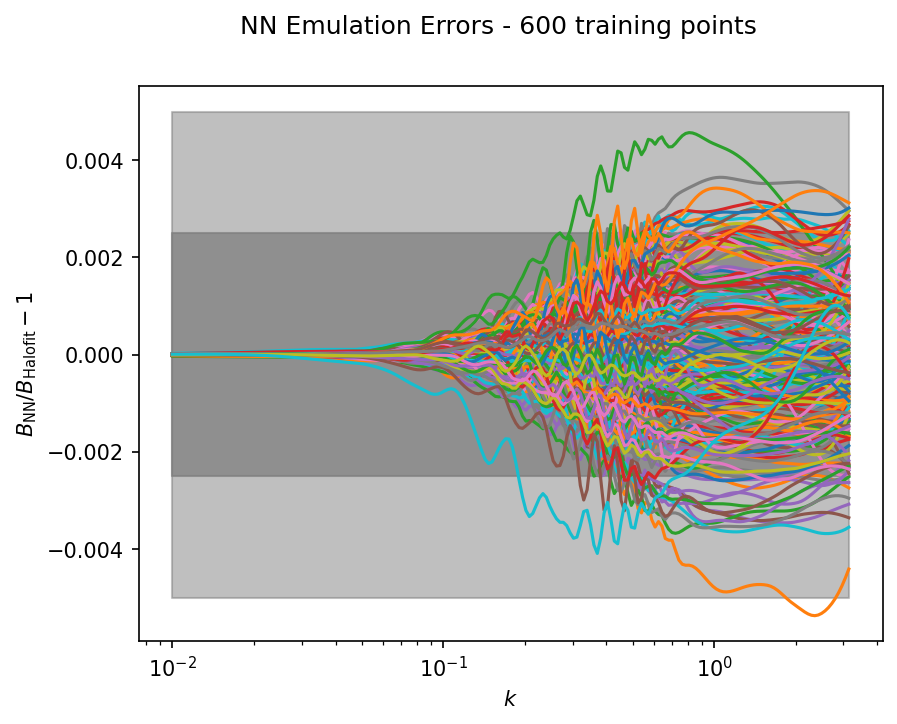

In [7]:
fig, ax = nn_keras.plot_errors(testSets["200_wa"])
fig.suptitle(f"NN Emulation Errors - {len(trainSet.lhs)} training points")
ax.set_xlabel(r"$k$")
ax.set_ylabel(r"$B_\mathrm{NN}/B_\mathrm{Halofit} - 1$")
fig.savefig(f"Figures/NN_ERRORS_T{len(trainSet.lhs)}_WA.pdf", bbox_inches="tight")

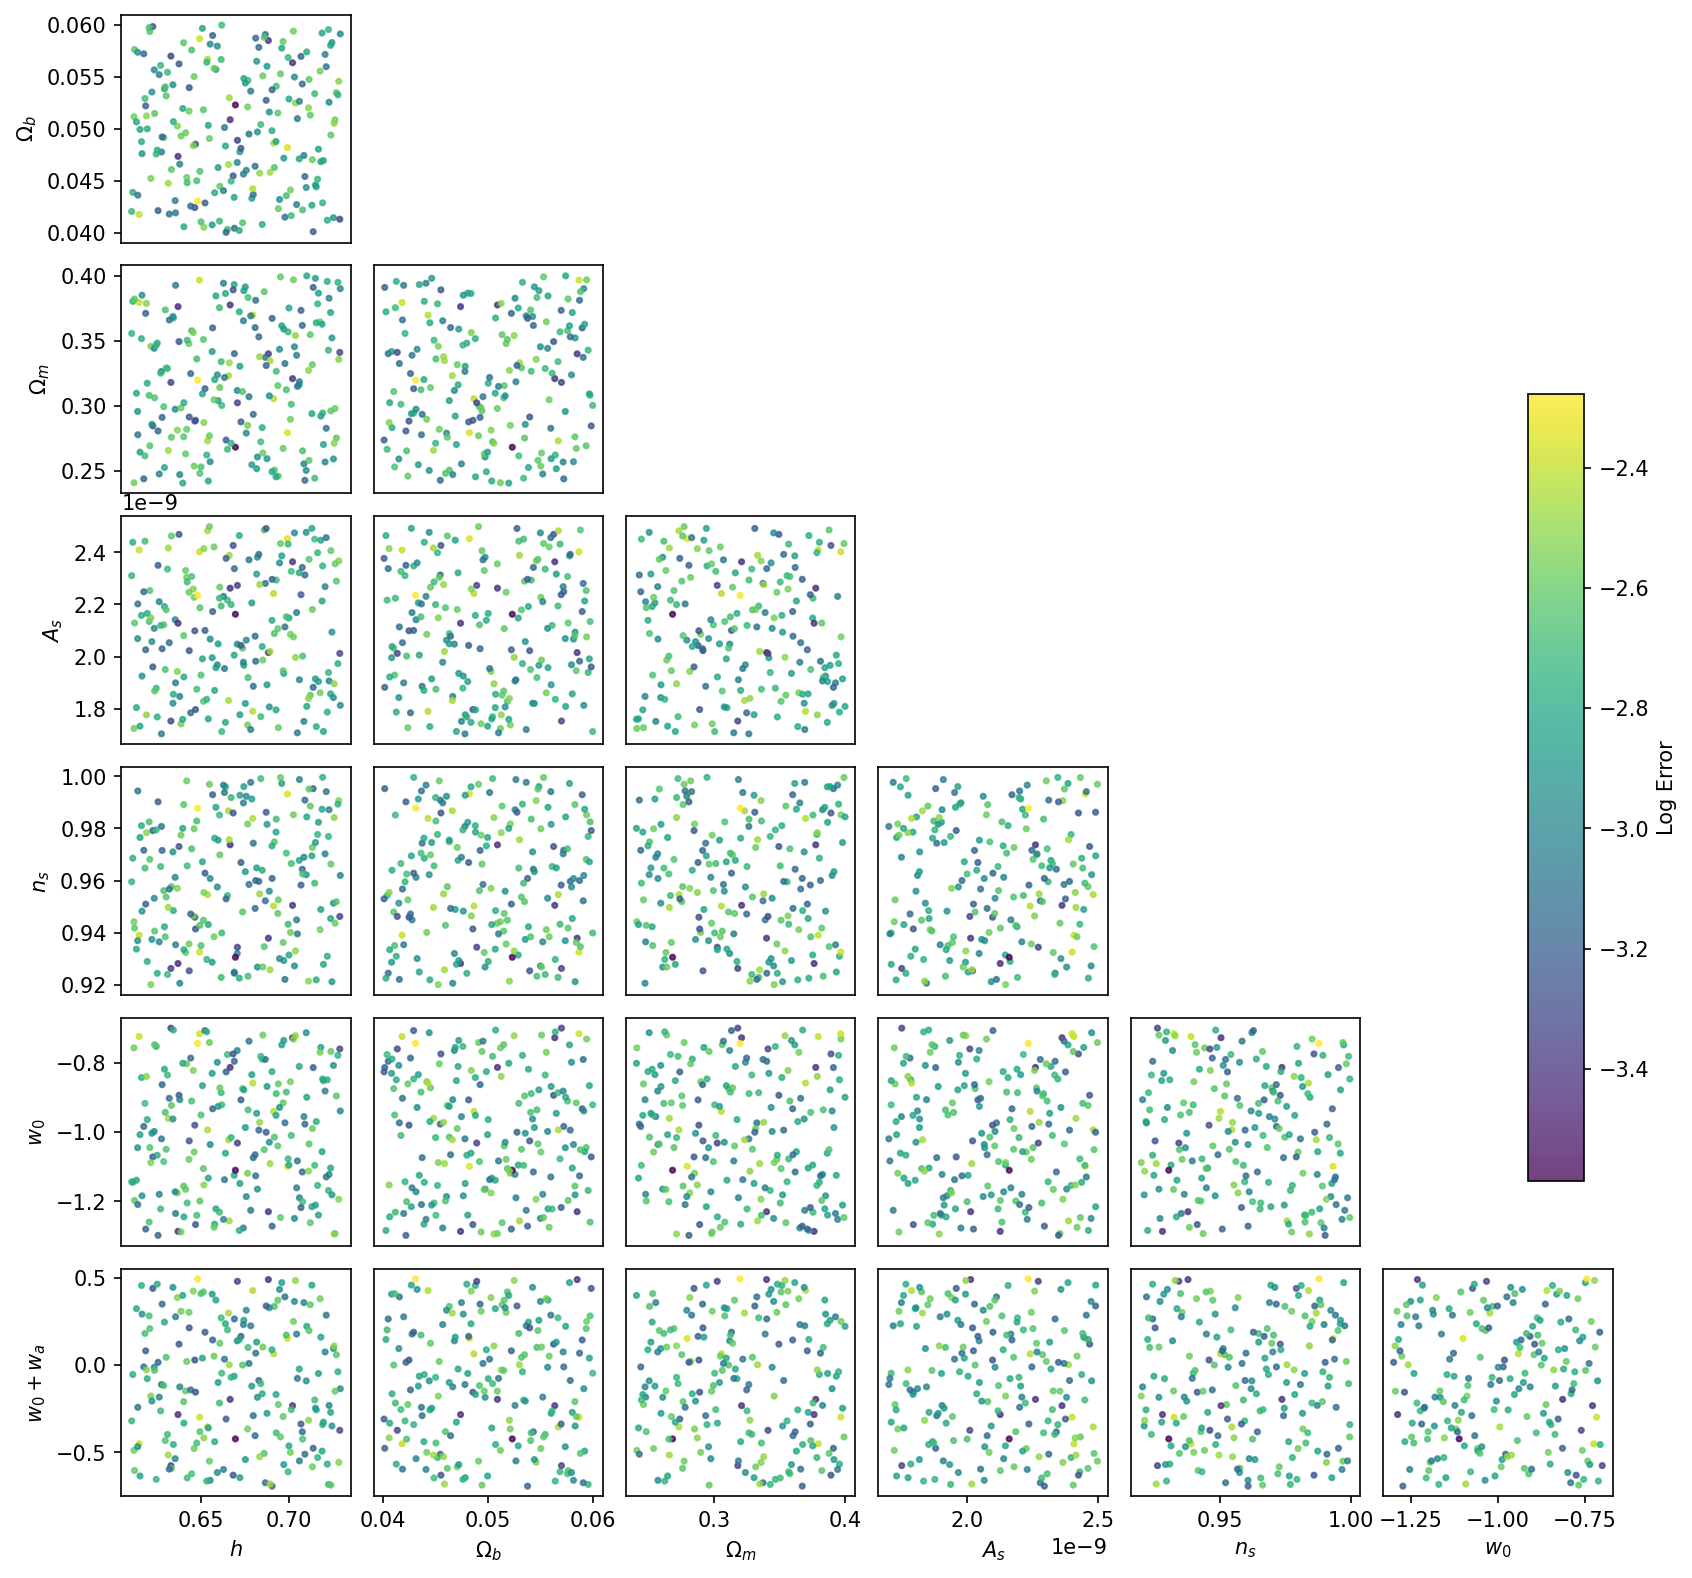

In [5]:
testSets["200_wa"].plot_lhs(model_to_map_errors=nn_keras)
plt.show()

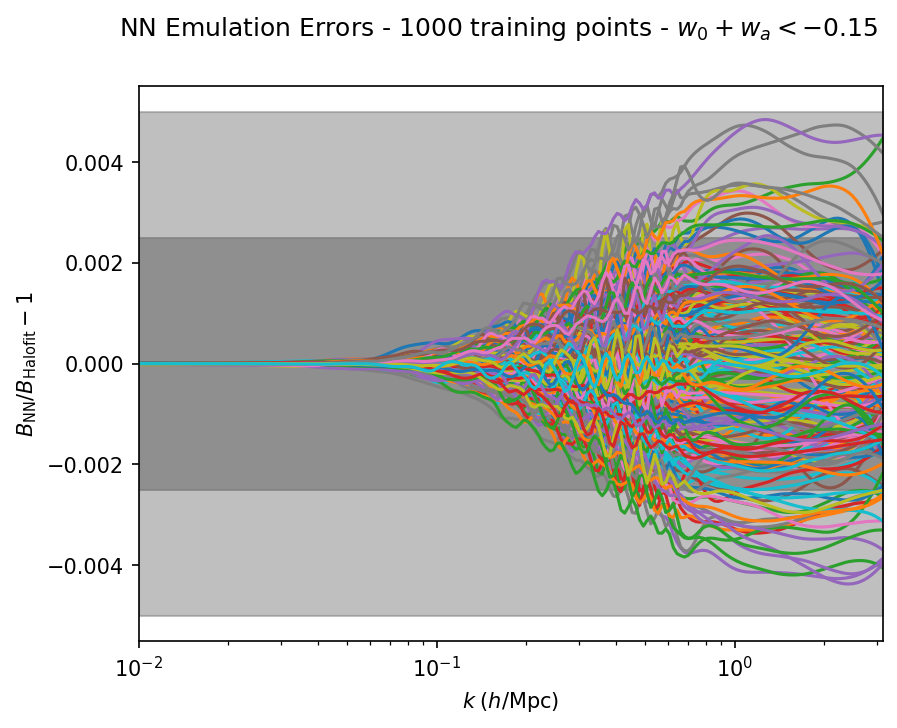

In [10]:
fig, axs = nn_keras.plot_errors(testSets["200_015"])
axs.set_xlabel(r"$k \; (h/\mathrm{Mpc})$")
axs.set_ylabel(r"$B_\mathrm{NN}/B_\mathrm{Halofit} - 1$")
axs.set_xlim([trainSet.ks[0], trainSet.ks[-1]])
fig.suptitle(fr"NN Emulation Errors - {len(trainSet.lhs)} training points - $w_0 + w_a < -0.15$")
fig.savefig("NN_ERRORS_UPPER015_TRAIN1000.pdf", bbox_inches="tight")

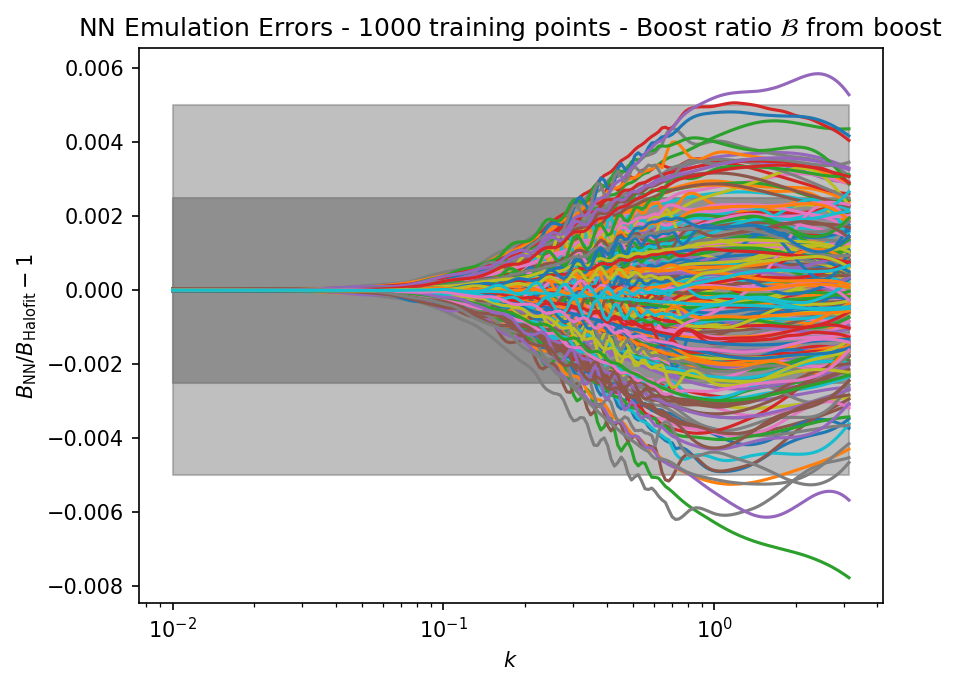

In [13]:
import copy
nn_boost = utils.load_model("models/NN_T1000_L3_N2048.model")
for point, boost_ratio in zip(testSets["200_boostratio"].lhs, testSets["200_boostratio"].boost_ratio):
    boost = nn_boost.predict(np.array(point).reshape(1, -1))[0]
    proj = copy.copy(point)
    proj[-2] = -1
    proj[-1] = -1
    boost_proj = nn_boost.predict(proj.reshape(1, -1))[0]
    boost_ratio_pred = boost/boost_proj
    error = boost_ratio_pred/boost_ratio - 1
    plt.semilogx(testSets["200_boostratio"].ks, error)
plt.title(r"NN Emulation Errors - 1000 training points - Boost ratio $\mathcal{{B}}$ from boost")
plt.xlabel(r"$k$")
plt.ylabel(r"$B_\mathrm{NN}/B_\mathrm{Halofit} - 1$")
plt.fill_between(testSets["200_boostratio"].ks, -0.0025, 0.0025, color="gray", alpha=0.75)
plt.fill_between(testSets["200_boostratio"].ks, -0.005, 0.005, color="gray", alpha=0.5)
plt.savefig("Figures/NN_ERRORS_T1000_BR_FROM_B.pdf", bbox_inches="tight")